In [1]:
import os
import gc
from math import ceil
from typing import Tuple, Union

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import wandb
from tqdm import tqdm
from datasets import load_dataset
from kornia.color import yuv_to_rgb, rgb_to_yuv

from colorizer import Colorizer
from dataloader import NoisyImageNetDataset

/scratch/swayam/miniconda3/envs/mast3r/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Restorer(nn.Module):
    """Model that colorizes and upscales the images."""
    def __init__(
            self,
            kernel_size: Union[int, Tuple[int, int]] = 5,
            sigma_color: float = 0.1,
            sigma_space: Union[float, Tuple[float, float]] = 1.5,
        ) -> None:
        super().__init__()

        self.colorizer = Colorizer(kernel_size, sigma_color, sigma_space)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model.

        Args:
            x: The input tensor of shape (BATCH_SIZE, 1, 270, 512).
        Returns:
            - uv_channels: The predicted UV channels of shape (BATCH_SIZE, 2, 270, 512).
        """
        uv_channels = self.colorizer(x)  # Shape: (BATCH_SIZE, 2, 270, 512)
        return uv_channels

In [3]:
LR                 = 1e-4
DEVICE             = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
WANDB_LOG          = True
CACHE_DIR          = "/scratch/swayam/other_stuff/DIP/ImageNet-1k/"
NUM_EPOCHS         = 1
BATCH_SIZE         = 16
WEIGHT_DECAY       = 1e-2
VAL_FREQUENCY      = 250
MAX_VAL_BATCHES    = 50
SCHEDULER_FACTOR   = 0.8
SCHEDULER_PATIENCE = 2
WANDB_RUN_NAME     = f"fix_uv_colorizer_bug_{LR}_{WEIGHT_DECAY}_{VAL_FREQUENCY}_{MAX_VAL_BATCHES}"
CHECKPOINT_DIR     = "/scratch/swayam/other_stuff/DIP/checkpoints/"

In [4]:
val_dataset = load_dataset(
    'imagenet-1k', split='validation', streaming=True,
    cache_dir=CACHE_DIR, trust_remote_code=True
).shuffle()

noisy_val_dataset = NoisyImageNetDataset(val_dataset)

In [5]:
sample = next(iter(noisy_val_dataset))

denoised_gray = sample['denoised_gray'].unsqueeze(0).to(DEVICE)
# denoised_gray = sample['denoised_gray'].to(DEVICE)
original_rgb  = sample['original_rgb'].unsqueeze(0).to(DEVICE)

In [6]:
model = Restorer().to(DEVICE)
checkpoint_name = "full_val_scale_fix_uv_colorizer_bug_0.0001_0.01_2500_epoch_1_batch_20000.pth"

model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, checkpoint_name))['model_state_dict'])
model.eval()

with torch.no_grad():
    uv_channels = model(denoised_gray)

pred_rgb = yuv_to_rgb(torch.cat([denoised_gray, uv_channels], dim=1))

/tmp/ipykernel_3259919/2363551351.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, checkpoint_name))['model_

In [7]:
# print the min u, max u, min v, max v
print(f"Min U: {uv_channels[0, 0].min().item()}")
print(f"Max U: {uv_channels[0, 0].max().item()}")
print(f"Min V: {uv_channels[0, 1].min().item()}")
print(f"Max V: {uv_channels[0, 1].max().item()}")

print(f"Min Y: {denoised_gray[0].min().item()}")
print(f"Max Y: {denoised_gray[0].max().item()}")

print(f"Min R: {pred_rgb[0, 0].min().item()}")
print(f"Max R: {pred_rgb[0, 0].max().item()}")
print(f"Min G: {pred_rgb[0, 1].min().item()}")
print(f"Max G: {pred_rgb[0, 1].max().item()}")
print(f"Min B: {pred_rgb[0, 2].min().item()}")
print(f"Max B: {pred_rgb[0, 2].max().item()}")

Min U: -0.052978064864873886
Max U: -0.0008787387050688267
Min V: -0.008936363272368908
Max V: 0.04077418893575668
Min Y: 0.12941177189350128
Max Y: 0.8745098114013672
Min R: 0.13577553629875183
Max R: 0.8909542560577393
Min G: 0.13175822794437408
Max G: 0.879803478717804
Min B: 0.09151308983564377
Max B: 0.8073161840438843


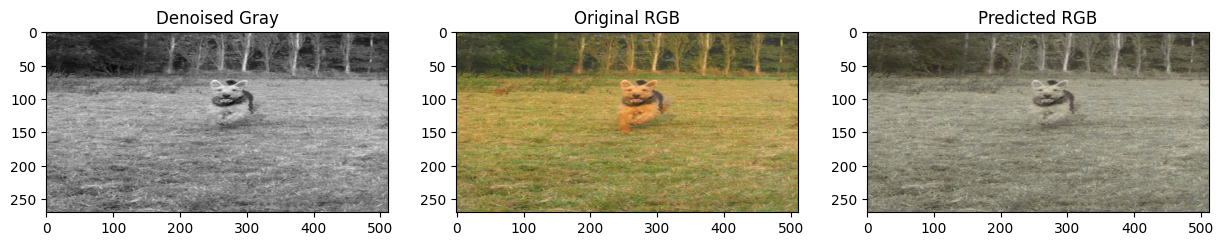

In [8]:
import matplotlib.pyplot as plt
import numpy as np

denoised_gray_plt = denoised_gray.squeeze().cpu().numpy()
original_rgb_plt  = original_rgb.squeeze().permute(1, 2, 0).cpu().numpy()
pred_rgb_plt      = pred_rgb.squeeze().permute(1, 2, 0).cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(denoised_gray_plt, cmap='gray')
axs[0].set_title("Denoised Gray")
axs[1].imshow(original_rgb_plt)
axs[1].set_title("Original RGB")
axs[2].imshow(pred_rgb_plt)
axs[2].set_title("Predicted RGB")
plt.show()

In [9]:
# run model over some 500 images and save the plots: denoised_gray, original_rgb, pred_rgb in a folder

results_folder = './results'
os.makedirs(results_folder, exist_ok=True)

for i, sample in enumerate(tqdm(noisy_val_dataset)):
    denoised_gray = sample['denoised_gray'].unsqueeze(0).to(DEVICE)
    original_rgb  = sample['original_rgb'].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        uv_channels = model(denoised_gray)

    pred_rgb = yuv_to_rgb(torch.cat([denoised_gray, uv_channels], dim=1))

    denoised_gray_plt = denoised_gray.squeeze().cpu().numpy()
    original_rgb_plt  = original_rgb.squeeze().permute(1, 2, 0).cpu().numpy()
    pred_rgb_plt      = pred_rgb.squeeze().permute(1, 2, 0).cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(denoised_gray_plt, cmap='gray')
    axs[0].set_title("Denoised Gray")
    axs[1].imshow(original_rgb_plt)
    axs[1].set_title("Original RGB")
    axs[2].imshow(pred_rgb_plt)
    axs[2].set_title("Predicted RGB")
    plt.savefig(os.path.join(results_folder, f"{i}.png"))
    plt.close()

    if i == 500:
        break

1it [00:57, 57.19s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07669457..1.0432172].
2it [00:57, 23.74s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04518388..0.9885071].
3it [00:57, 12.99s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05522918..1.0349765].
4it [00:57,  7.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08607204..1.0157857].
5it [00:58,  5.15s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.034077574..1.0345947].
6it [00:58,  3.47s/it]WARNING:matp